# Clustering with Hyperparameter Optimization

#### PROBLEM STATEMENT
* Many unsupervised clustering problems start with visualizing the data to figure out how many clusters should be created.
* While this is feasible when the number of features is small, it becomes harder to do as the number of features increase.
* Moreover, real world data is noisy and it is not often clear how many clusters should be used (unlike with toy examples).
* How does one programatically compute the number of clusters to use?

#### BASIC SOLUTION
* Perform Grid Search to find the best hyperparameters
* While this solution is fine for many use cases, the issue is that the user still needs to predefine the hyperparameter values (discrete) to try during the grid search.
* In many cases, the values to try are hard to determine ahead of time so the user has to take the best guess. Moreover, only discrete hyperparameter values can be evaluated using this approach
* In addition, this can quickly get out of hand. For example, if we just try 5 values for 4 hyperparameters each, we get 625 combinations to evaluate!!!

#### BETTER SOLUTION
* Use an optimization technique and let the optimizer figure out the best set of hyperparameters.
* The advantage is that the user has to just specify the range of values to try for the hyperparameters and the optimizer will figure out the best value within that range.
* Since we are not using a brute force grid search approach, we can obtain the optimal hyperparanmeters in much fewer iterations and are also not restricted to using discrete values for hyperparaneters dueing the serach.

**This notebook will show how hyperparameter optiization can be done using the more library Cluster Helper object.** While this example shows the use only with the KMeans helper object, the same can be done using the Agglomerative helper objct as well.

In [1]:
from more import hyperopt_helper as hh
from more import viz_helper as vh
from more.scikit_helper.cluster import KMeansHelper as kmh
# from more.scikit_helper.cluster import AgglomerativeHelper as agh  # only needed if using the agglomerative Helper

In [2]:
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
import pandas as pd

import hyperopt

In [3]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

kmeans = KMeans(n_clusters=8)

### Using KMeans Helper Class to do the optimization

* In internal hyperparameter optimization in the cluster helper class is built using the hyperopt library
* In order to perform hyperparameter optimization using the helper class, we need 3 things
    - The set of paranmeters that will remain constant during the optiization
    - The set of parameers that will vary during the optimization inclusing the search space
    - The loss function that should be minimized during the optimization process

In [4]:
# Define the parameters that will not change during huperparameter optimization
const_params = dict({'init': 'k-means++'
                     ,'random_state': 101
                     ,'n_jobs': -1
                     ,'algorithm': 'auto'
                    })

In [5]:
# Define the search space to use dueing the optimization process
space = {'n_clusters': hyperopt.hp.choice('n_clusters', np.arange(3, 11, dtype=int)),
         'n_init': hyperopt.hp.choice('n_init', np.arange(10, 100, dtype=int)),
         'max_iter': hyperopt.hp.choice('max_iter', np.arange(300, 500, dtype=int)) }

In [6]:
# Define the loss function that has to be minimized during hyper parameter optimization.
def loss_function (model, X, y):
    """
    loss_function must have 3 arguments for 
    (1)  Model
    (2) X (Features)
    (3) y (labels) - Do not have to use this internally for unsupervised problems but needs to be in the argument list
    
    Also, any libraries used specifically must be imported within this function.
    """
    import sklearn.metrics as mt
    
    # Note that you can also choose to do CV here and pick the mean value of the metric
    # This would generally be recommeded for a production system
    # Since this is an example code, we will skip this for now.
    model.fit(X)
    measure_s = -mt.silhouette_score(X, model.labels_,random_state=101)
    
    return(measure_s)

In [7]:
# Define the K-means helper class object
kmeans = kmh(X=pd.DataFrame(X, columns=iris.feature_names), n_clusters=8, n_jobs=-1, scaled=False
             , space = space, const_params=const_params, loss_fun = loss_function)


##### **Note that we passed**

1. the constant hyper parameters, 
2. hyperparameers search space and 
3. the desired loss function during the instantiation

**These will be used during Hyperparameter Optimization**

In [8]:
kmeans.train_best_model() # Performing Hyperparameter Search using Optimization

evaluating params={'max_iter': 472, 'n_clusters': 6, 'n_init': 39, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.3648340039670018
evaluated 1 times
evaluating params={'max_iter': 426, 'n_clusters': 5, 'n_init': 62, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.4887488870931048
evaluated 2 times
evaluating params={'max_iter': 442, 'n_clusters': 3, 'n_init': 63, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.5528190123564091
evaluated 3 times
evaluating params={'max_iter': 309, 'n_clusters': 3, 'n_init': 95, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.5528190123564091
evaluated 4 times
evaluating params={'max_iter': 337, 'n_clusters': 7, 'n_init': 61, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.3568618172536361
evaluated 5 times
evaluating params={'max_iter': 485, 'n_clusters': 10, 'n_init': 7

In [9]:
kmeans.best_params

{'max_iter': 442,
 'n_clusters': 3,
 'n_init': 63,
 'init': 'k-means++',
 'random_state': 101,
 'n_jobs': -1,
 'algorithm': 'auto'}

In [10]:
kmeans.cluster_means()

labels,0,1,2
sepal length (cm),5.901613,5.006,6.850000
sepal width (cm),2.748387,3.428,3.073684
petal length (cm),4.393548,1.462,5.742105
petal width (cm),1.433871,0.246,2.071053


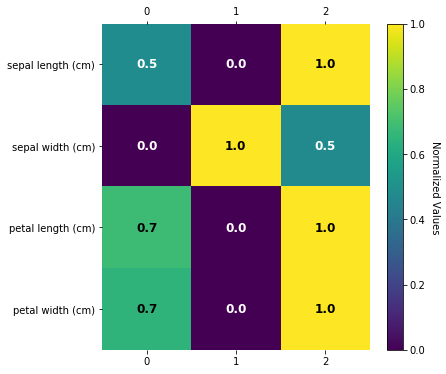

In [11]:
kmeans.plot_means_heatmap(annot=True)

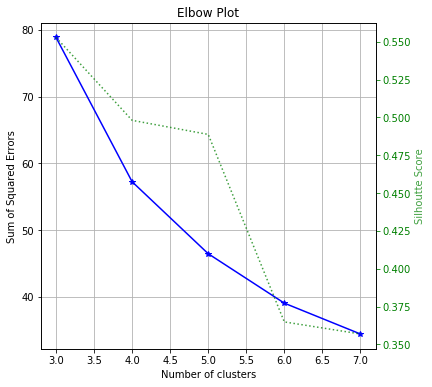

In [12]:
kmeans.plot_elbow_curve(cluster_ranges=[3,4,5,6,7],second_metric='silhoutte',n_jobs=-1)

## Using external hyperparameter optimization with KMeans Helper Class

We can use an external optimization engine (instead of using the internal hyperopt optimization engine). 
The following section describes how this can be done using scikit-optimize.

In [13]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import skopt.plots

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
# Preprocessing and Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

# Define the space
space = [Integer(3, 100, name='n_clusters')
         ,Integer(10, 100, name='n_init')
         ,Integer(300, 500, name='max_iter')
        ]

# Define the objective function (loss function) to be minimized
@use_named_args(space)
def objective(**params):
    kmeans_model = KMeans(init='k-means++',random_state=101,n_jobs=-1,**params)
    std_scl = StandardScaler()
    piped_object = Pipeline([('scale', std_scl),  # do this
                             ('kmeans_model', kmeans_model)]) # and then do this

    piped_object.fit(X)
    
    measure_s = -mt.silhouette_score(X,kmeans_model.labels_,random_state=101)
    return (measure_s)

In [15]:
kmeans_gp = gp_minimize(objective,space
                       ,n_random_starts=10 # 10 random points to start 
                       ,n_calls=25 # pick 25 points total (including n_random_starts) to find optimal combination of hyperparameters
                       ,verbose=True, n_jobs=-1, random_state=101)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7721
Function value obtained: -0.1563
Current minimum: -0.1563
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1290
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3663
Function value obtained: -0.1540
Current minimum: -0.5062
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2363
Function value obtained: -0.1144
Current minimum: -0.5062
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1845
Function value obtained: -0.3172
Current minimum: -0.5062
Iteration No: 6 started. 

C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5783
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.6764
Function value obtained: -0.1153
Current minimum: -0.5062
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5515
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6410
Function value obtained: -0.2051
Current minimum: -0.5062
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.7897
Function value obtained: -0.0950
Current minimum: -0.5062
Iteration No: 20 st

C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5454
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 22 started. Searching for the next optimal point.


C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.6576
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6572
Function value obtained: -0.2531
Current minimum: -0.5062
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7778
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7444
Function value obtained: -0.1787
Current minimum: -0.5062


In [16]:
print('Best score: {} | Best params: {}'.format(kmeans_gp.fun, kmeans_gp.x))

Best score: -0.5061527484935536 | Best params: [3, 58, 358]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000124C78B8828>,
      dtype=object)

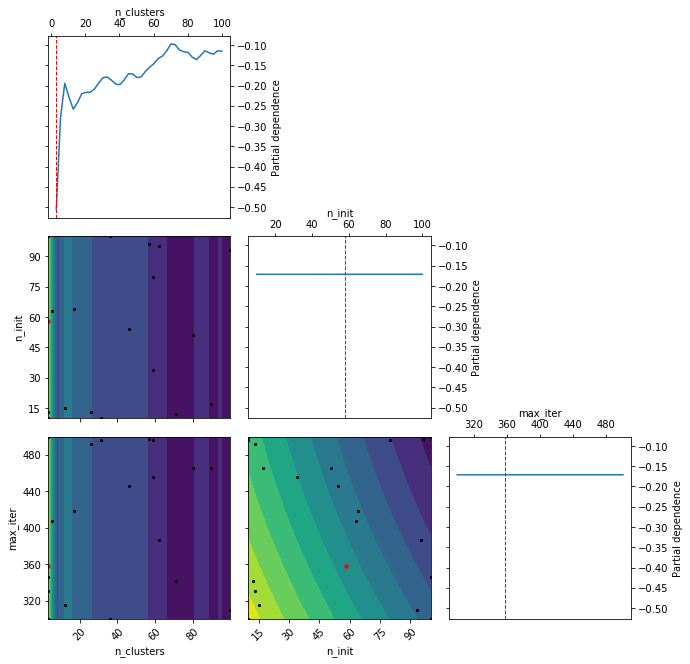

In [17]:
skopt.plots.plot_objective(kmeans_gp, size=3, dimensions=['n_clusters','n_init','max_iter'])

* NOTE that the plot is showing the negative of Silhoutte Score
* From the above partial dependence plot, we see that the the maximum Silhoutte score is obrained at n_clusters = 3 (all other paraneters being kept constant) 

In [18]:
# Prepare model with complete list of "best" parameters
best_params = {'n_clusters':  kmeans_gp.x[0] 
              ,'n_init':  kmeans_gp.x[1]
              ,'max_iter':  kmeans_gp.x[2]
             }
best_params.update(const_params)
print(best_params)
kmeans_best = KMeans(**best_params)

{'n_clusters': 3, 'n_init': 58, 'max_iter': 358, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}


In [19]:
# Update helper object with "best" model 
kmeans.set_model(kmeans_best)

In [20]:
# Train and evaluate as usual
kmeans.train().evaluate_fit()

Silhouette Coefficient: 0.5528190123564091


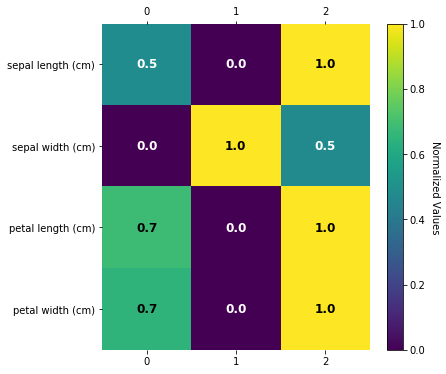

In [21]:
kmeans.plot_means_heatmap(annot=True)

* We get the same results as that obtained by using the internal Hyperopt method. 
* Note however that this may not always be the case as the 2 methods (internal hyperopt and external optimization) may return different values of the "best" hyperparameters